In [200]:
import json

# models = ['gpt-4o', 'llama']
models = ['gpt-4o', 'gpt-4o-mini', 'mixtral', 'llama']
workloads = ["fever"]
# workloads = ["real-estate", "biodex"]
baseline_to_execution_stats = {workload: {} for workload in workloads}
baseline_to_records = {workload: {} for workload in workloads}
for workload in workloads:
    for model in models:
        with open(f"opt-profiling-data/{workload}-baseline-{model}-profiling.json", 'r') as f:
            baseline_to_execution_stats[workload][model] = json.load(f)
    
        with open(f"opt-profiling-data/{workload}-baseline-{model}-records.json", 'r') as f:
            baseline_to_records[workload][model] = json.load(f)


In [201]:
NUM_SAMPLES = [10]
# NUM_SAMPLES = [5, 10, 15, 20, 25]
RANKS = [4]
# RANKS = [2, 4, 6, 8, 10]
rank_num_samples = []
for n in NUM_SAMPLES:
    for rank in RANKS:
        if rank + 1 > n:
            continue
        rank_num_samples.append((rank, n))

pz_to_execution_stats = {workload: {rank: {n: None} for rank, n in rank_num_samples} for workload in workloads}
pz_to_records = {workload: {rank: {n: None} for rank, n in rank_num_samples} for workload in workloads}
for workload in workloads:
    for rank, n in rank_num_samples:
        with open(f"opt-profiling-data/{workload}-rank-{rank}-num-samples-{n}-profiling.json", 'r') as f:
            pz_to_execution_stats[workload][rank][n] = json.load(f)
    
        with open(f"opt-profiling-data/{workload}-rank-{rank}-num-samples-{n}-records.json", 'r') as f:
            pz_to_records[workload][rank][n] = json.load(f)


In [202]:
# pz_to_records['fever'][4][10]
# baseline_to_execution_stats

In [203]:
def compute_accuracy_fever(records, ground_truth_file = "testdata/paper_test.jsonl"):
    with open(ground_truth_file, "r") as f:
        ground_truth = [json.loads(line) for line in f]
    
    claims = [record["claim"] for record in records]
    output_labels = [str(record["label"]).upper() for record in records]
    
    accuracy = []
    
    expected_labels = {}
    
    for entry in ground_truth:
        claim = entry["claim"]
        if str(claim) in claims:
            if entry["label"] == "SUPPORTS":
                expected_label = 'TRUE'
            else:
                expected_label = 'FALSE'
            expected_labels[claim] = expected_label
            
    assert(len(expected_labels) == len(output_labels))
    
    for i in range(len(claims)):
#         print (claims[i], expected_labels[claims[i]], output_labels[i])
        if output_labels[i] != expected_labels[claims[i]]:
            accuracy.append(0)
        else:
            accuracy.append(1)
    
    return sum(accuracy) * 1.0 / len(accuracy)

In [204]:
# records = baseline_to_records['fever']['gpt-4o']
# records = pz_to_records['fever'][4][10]
# accuracy = compute_accuracy_fever(records, ground_truth_file)
# print(accuracy)
print(pz_to_execution_stats['fever'][4][10]['plan_stats'][list(pz_to_execution_stats['fever'][4][10]['plan_stats'].keys())[1]]['plan_str'])

 0. MarshalAndScanDataOp -> FeverClaimsSchema 

 1. FeverClaimsSchema -> NonLLMConvert -> FeverIntermediateSchema
    (claim) -> (claim, relevant_wikipedia_arti)
    UDF: functools.partial(<function get_relevant_content at 0x10b07e5c0>, <ragatouille.RAGPretrainedModel.RAGPretrainedModel object at 0x134fdc800>, 10)

 2. FeverIntermediateSchema -> LLMConvertBonded -> FeverOutputSchema
    (claim, relevant_wikipedia_arti) -> (claim, label, relevant_wikiped)
    Model: Model.GPT_4o
    Prompt Strategy: PromptStrategy.DSPY_COT_QA




In [205]:
### REAL-ESTATE Metrics ###
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import pandas as pd
import datasets

def compute_biodex_target_record(entry):
    target_lst = entry['target'].split('\n')
    label_dict = {
        "serious": int(target_lst[0].split(':')[-1]),
        "patientsex": int(target_lst[1].split(':')[-1]),
        "drugs": [drug.strip().lower() for drug in target_lst[2].split(':')[-1].split(",")],
        "reactions": [reaction.strip().lower() for reaction in target_lst[3].split(':')[-1].split(",")],
    }
    return label_dict

def get_set_precision_and_recalls(preds: list, targets: list):
    # lower-case all entries
    preds = [pred.lower() for pred in preds]
    targets = [target.lower() for target in targets]

    # compute precision and recall
    s_preds = set(preds)
    s_targets = set(targets)

    intersect = s_preds.intersection(s_targets)

    precision = len(intersect) / len(s_preds) if len(s_preds) > 0 else 0.0
    recall = len(intersect) / len(s_targets)

    return precision, recall

def biodex_record_score(record_dict, target_dict):
    serious_sim = record_dict['serious'] == target_dict['serious']
    patientsex_sim = record_dict['patientsex'] == target_dict['patientsex']

    drugs_p, drugs_r = get_set_precision_and_recalls(record_dict['drugs'], target_dict['drugs'])
    reactions_p, reactions_r = get_set_precision_and_recalls(record_dict['reactions'], target_dict['reactions'])

    weights = [1 / 6, 1 / 6, 1 / 3, 1 / 3]
    precision = [serious_sim, patientsex_sim, drugs_p, reactions_p]
    recall = [serious_sim, patientsex_sim, drugs_r, reactions_r]

    precision = sum([w * p for w, p in zip(weights, precision)])
    recall = sum([w * r for w, r in zip(weights, recall)])

    if precision and recall:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0
    return precision, recall, f1

def compute_metrics(records, id_to_label, workload):
    precision, recall, f1 = None, None, None
    if workload == "real-estate":
        # get the list of labels from the dataset
        y_true = [
            int(id_to_label[f"listing{idx}"]) for idx in range(26, 101)
        ]
    
        # get the list of predictions from the program
        predicted_listings = set(map(lambda elt: elt['listing'], records))
        y_pred = [
            1 if f"listing{idx}" in predicted_listings else 0
            for idx in range(26, 101)
        ]
        
        # compute metrics
        class_precision, class_recall, class_f1, _ = precision_recall_fscore_support(y_true, y_pred)
        precision, recall, f1 = class_precision[1], class_recall[1], class_f1[1]

    elif workload == "biodex":
        f1_scores = []
        for record in records:
            target = id_to_label[record['pmid']]
            _, _, f1 = biodex_record_score(record, target)
            f1_scores.append(f1)

        # compute avg. weighted f1 score
        f1 = np.mean(f1_scores)

    return precision, recall, f1

# #### create dictionary mapping ids --> groundtruth label for each workload
# id_to_label_dict = {workload: None for workload in workloads}
# # Real-Estate
# real_estate_labels_df = pd.read_csv("testdata/groundtruth/real-estate-eval-100.csv")
# id_to_label_dict["real-estate"] = {
#     row['listing']: row['label']
#     for _, row in real_estate_labels_df.iterrows()
#     if int(row['listing'].split('listing')[-1]) > 25
# }
# # BioDex
# biodex_dataset = datasets.load_dataset("BioDEX/BioDEX-ICSR")
# biodex_test_dataset = [biodex_dataset['test'][idx] for idx in range(len(biodex_dataset['test']))]
# rng = np.random.default_rng(seed=42)
# rng.shuffle(biodex_test_dataset)
# biodex_test_dataset = biodex_test_dataset[:500]
# id_to_label_dict["biodex"] = {
#     entry['pmid']: compute_biodex_target_record(entry)
#     for entry in biodex_test_dataset
# }

# Fever
ground_truth_file = "testdata/paper_test.jsonl"

# compute precision, recall, f1 for each baseline and place it in the execution_stats
for workload in workloads:
#     id_to_label = id_to_label_dict[workload]
    for model in models:
        records = baseline_to_records[workload][model]
        accuracy = compute_accuracy_fever(records, ground_truth_file)
        baseline_to_execution_stats[workload][model]['accuracy'] = accuracy
#         precision, recall, f1 = compute_metrics(records, id_to_label, workload)
#         baseline_to_execution_stats[workload][model]['precision'] = precision
#         baseline_to_execution_stats[workload][model]['recall'] = recall
#         baseline_to_execution_stats[workload][model]['f1'] = f1


# compute precision, recall, f1 for each (rank, num_samples) pair and place it in the execution_stats
for workload in workloads:
#     id_to_label = id_to_label_dict[workload]
    for rank, n in rank_num_samples:
        records = pz_to_records[workload][rank][n]
        accuracy = compute_accuracy_fever(records, ground_truth_file)
        pz_to_execution_stats[workload][rank][n]['accuracy'] = accuracy
#         precision, recall, f1 = compute_metrics(records, id_to_label, workload)
#         pz_to_execution_stats[workload][rank][n]['precision'] = precision
#         pz_to_execution_stats[workload][rank][n]['recall'] = recall
#         pz_to_execution_stats[workload][rank][n]['f1'] = f1


# # compute precision, recall, f1 for each baseline and place it in the execution_stats
# for workload in workloads:
#     id_to_label = id_to_label_dict[workload]
#     for model in models:
#         records = baseline_to_records[workload][model]
#         precision, recall, f1 = compute_metrics(records, id_to_label, workload)
#         baseline_to_execution_stats[workload][model]['precision'] = precision
#         baseline_to_execution_stats[workload][model]['recall'] = recall
#         baseline_to_execution_stats[workload][model]['f1'] = f1

# # compute precision, recall, f1 for each (rank, num_samples) pair and place it in the execution_stats
# for workload in workloads:
#     id_to_label = id_to_label_dict[workload]
#     for rank, n in rank_num_samples:
#         records = pz_to_records[workload][rank][n]
#         precision, recall, f1 = compute_metrics(records, id_to_label, workload)
#         pz_to_execution_stats[workload][rank][n]['precision'] = precision
#         pz_to_execution_stats[workload][rank][n]['recall'] = recall
#         pz_to_execution_stats[workload][rank][n]['f1'] = f1


In [206]:
print(pz_to_execution_stats['fever'][4][10]['accuracy'])
print(baseline_to_execution_stats['fever']['gpt-4o']['accuracy'])

0.9333333333333333
0.9333333333333333


In [207]:
# prepare data for plots
# compute baseline --> cost, baseline --> time, baseline --> f1
baseline_to_cost = {
    workload: {model: stats['total_execution_cost'] for model, stats in model_execution_stats.items()}
    for workload, model_execution_stats in baseline_to_execution_stats.items()
}
baseline_to_time = {
    workload: {model: stats['total_execution_time'] for model, stats in model_execution_stats.items()}
    for workload, model_execution_stats in baseline_to_execution_stats.items()
}
baseline_to_f1 = {
    workload: {model: stats['accuracy'] for model, stats in model_execution_stats.items()}
    for workload, model_execution_stats in baseline_to_execution_stats.items()
}

# baseline_to_f1 = {
#     workload: {model: stats['f1'] for model, stats in model_execution_stats.items()}
#     for workload, model_execution_stats in baseline_to_execution_stats.items()
# }

# # compute pz --> cost, pz --> time, pz --> f1, pz --> un-optimized time
pz_to_cost = {
    workload: {
        rank: {n: stats['total_execution_cost'] for n, stats in n_to_execution_stats.items()}
        for rank, n_to_execution_stats in rank_to_execution_stats.items()
    }
    for workload, rank_to_execution_stats in pz_to_execution_stats.items()
}
pz_to_time = {
    workload: {
        rank: {n: stats['total_execution_time'] for n, stats in n_to_execution_stats.items()}
        for rank, n_to_execution_stats in rank_to_execution_stats.items()
    }
    for workload, rank_to_execution_stats in pz_to_execution_stats.items()
}
pz_to_f1 = {
    workload: {
        rank: {n: stats['accuracy'] for n, stats in n_to_execution_stats.items()}
        for rank, n_to_execution_stats in rank_to_execution_stats.items()
    }
    for workload, rank_to_execution_stats in pz_to_execution_stats.items()
}
# pz_to_f1 = {
#     rank: {n: stats['f1'] for n, stats in n_to_execution_stats.items()}
#     for rank, n_to_execution_stats in pz_to_execution_stats.items()
# }
pz_to_no_opt_time = {
    workload: {
        rank: {n: stats['total_execution_time'] - stats['total_optimization_time'] for n, stats in n_to_execution_stats.items()}
        for rank, n_to_execution_stats in rank_to_execution_stats.items()
    }
    for workload, rank_to_execution_stats in pz_to_execution_stats.items()
}
# pz_to_no_opt_time = {
#     rank: {n: stats['total_execution_time'] - stats['total_optimization_time'] for n, stats in n_to_execution_stats.items()}
#     for rank, n_to_execution_stats in pz_to_execution_stats[workload].items()
# }

In [208]:
# baseline_to_time['biodex']['llama']

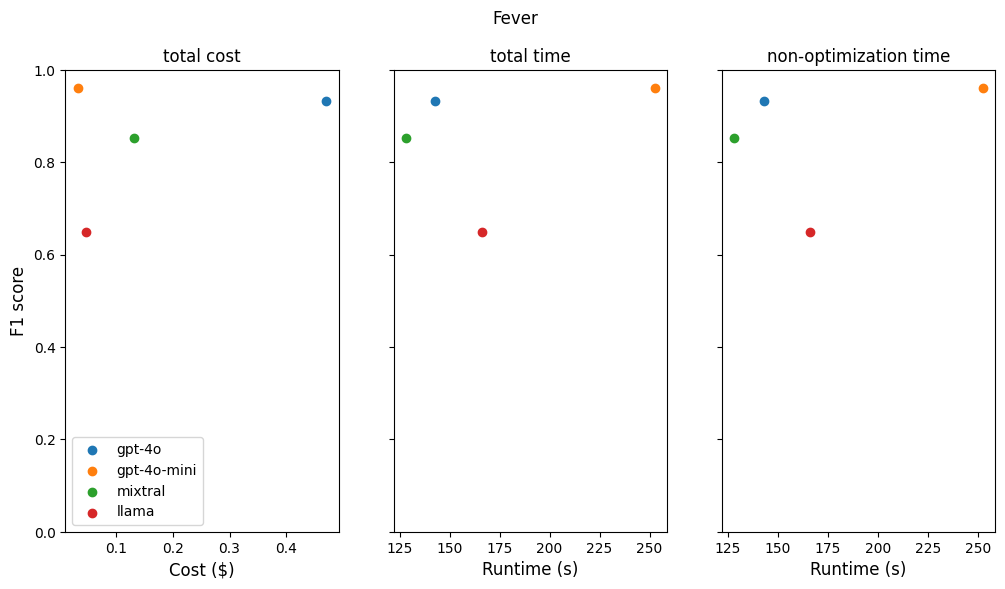

In [209]:
import matplotlib.pyplot as plt

for workload in workloads:
    # plot f1 vs cost
    fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 6))
    for model in models:
        axs[0].scatter([baseline_to_cost[workload][model]], [baseline_to_f1[workload][model]], label=model)
        axs[1].scatter([baseline_to_time[workload][model]], [baseline_to_f1[workload][model]], label=model)
        axs[2].scatter([baseline_to_time[workload][model]], [baseline_to_f1[workload][model]], label=model)
    
    # # num_samples-first view
    # cmap = plt.get_cmap('Greens')
    # for n in NUM_SAMPLES_:
    #     costs, times, no_opt_times, f1s = [], [], [], []
    #     for rank in RANKS_:
    #         if n in pz_to_cost[rank]:
    #             costs.append(pz_to_cost[rank][n])
    #             times.append(pz_to_time[rank][n])
    #             no_opt_times.append(pz_to_no_opt_time[rank][n])
    #             f1s.append(pz_to_f1[rank][n])
    
    #     n_to_color = {
    #         5: cmap(0.2),
    #         10: cmap(0.4),
    #         15: cmap(0.6),
    #         20: cmap(0.8),
    #         25: cmap(1.0),
    #     }
    #     color = n_to_color[n]
    #     axs[0].scatter(costs, f1s, color=color, label=f"n={n}")
    #     axs[1].scatter(times, f1s, color=color, label=f"n={n}")
    #     axs[2].scatter(no_opt_times, f1s, color=color, label=f"n={n}")

    workload_to_title = {
        "real-estate": "Real Estate Search",
        "biodex": "BioDex ICSR",
        "fever": "Fever"
    }
    workload_to_ylim = {
        "real-estate": [0.5, 1],
        "biodex": [0.0, 1.0],
        "fever": [0.0, 1.0]
    }
    
    fig.suptitle(workload_to_title[workload])
    axs[0].set_title("total cost")
    axs[1].set_title("total time")
    axs[2].set_title("non-optimization time")
    axs[0].set_ylim(workload_to_ylim[workload])
    axs[0].set_ylabel("F1 score", fontsize=12)
    axs[0].set_xlabel("Cost ($)", fontsize=12)
    axs[1].set_xlabel("Runtime (s)", fontsize=12)
    axs[2].set_xlabel("Runtime (s)", fontsize=12)
    axs[0].legend()
    plt.show()
    # fig.savefig(f"opt-results/{workload}-search-num-samples-view.png")

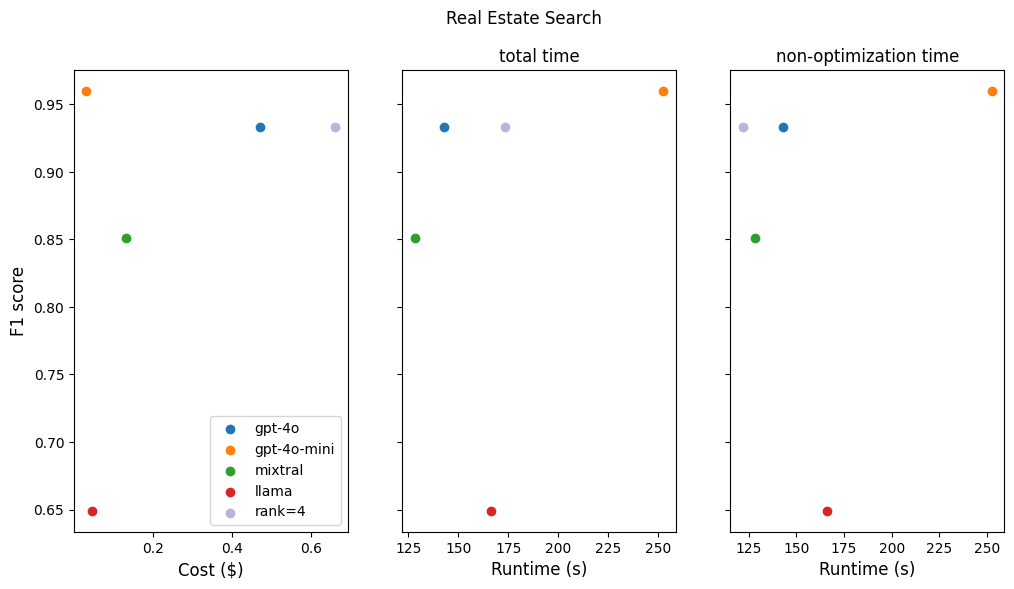

In [210]:
# plot f1 vs cost
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 6))
for model in models:
    axs[0].scatter([baseline_to_cost[workload][model]], [baseline_to_f1[workload][model]], label=model)
    axs[1].scatter([baseline_to_time[workload][model]], [baseline_to_f1[workload][model]], label=model)
    axs[2].scatter([baseline_to_time[workload][model]], [baseline_to_f1[workload][model]], label=model)

# rank-first view
cmap = plt.get_cmap('Purples')
for rank in RANKS:
    costs, times, no_opt_times, f1s = [], [], [], []
    for n in NUM_SAMPLES:
        if n in pz_to_cost[workload][rank]:
            costs.append(pz_to_cost[workload][rank][n])
            times.append(pz_to_time[workload][rank][n])
            no_opt_times.append(pz_to_no_opt_time[workload][rank][n])
            f1s.append(pz_to_f1[workload][rank][n])

    rank_to_color = {
        2: cmap(0.2),
        4: cmap(0.4),
        6: cmap(0.6),
        8: cmap(0.8),
        10: cmap(1.0),
    }
    color = rank_to_color[rank]
    axs[0].scatter(costs, f1s, color=color, label=f"rank={rank}")
    axs[1].scatter(times, f1s, color=color, label=f"rank={rank}")
    axs[2].scatter(no_opt_times, f1s, color=color, label=f"rank={rank}")    

fig.suptitle("Real Estate Search")
axs[1].set_title("total cost")
axs[1].set_title("total time")
axs[2].set_title("non-optimization time")
# axs[0].set_ylim([0.5, 1])
axs[0].set_ylabel("F1 score", fontsize=12)
axs[0].set_xlabel("Cost ($)", fontsize=12)
axs[1].set_xlabel("Runtime (s)", fontsize=12)
axs[2].set_xlabel("Runtime (s)", fontsize=12)
axs[0].legend()
plt.show()
fig.savefig("opt-results/real-estate-search-rank-view.png")

## Reconstruction Error

### Load Groundtruth Execution Data

In [71]:
import json
import numpy as np

num_samples_to_sentinel_plan_id = {
    "real-estate": {
        5: "2a2421605b",
        10: "46a03a2d0a",
        15: "94bd9534f3",
        20: "ebf38d7b56",
        25: "a6c9708fe5",
    },
    "biodex": {
        5: "386bb023ff",
        10: "ba83a40870",
        15: "711c5caae8",
        20: "df18b04389",
        25: "ba749e73f0",
    }
}

# STORE MAPPING FROM NUMBER OF SAMPLES --> GROUNDTRUTH DATA
num_samples_to_raw_matrices = {workload: {} for workload in workloads}
for workload in workloads:
    for n in [5, 10, 15, 20, 25]:
        raw_matrices_fp = f"opt-profiling-data/raw-matrices-n-{n}-{num_samples_to_sentinel_plan_id[workload][n]}.json"
        with open(raw_matrices_fp, 'r') as f:
            # load mapping from logical_op_id --> (per-metric) matrices
            raw_matrices = json.load(f)
    
            # convert serialized matrices back into numpy arrays
            for logical_op_id, matrices_dict in raw_matrices.items():
                metric_to_matrix = {}
                for metric, matrix in matrices_dict.items():
                    # ignore selectivity for now
                    if metric == "selectivity":
                        continue
    
                    metric_to_matrix[metric] = np.array(matrix)
    
                raw_matrices[logical_op_id] = metric_to_matrix
    
            # store dictionary of arrays
            num_samples_to_raw_matrices[workload][n] = raw_matrices


### Define Helpers

In [72]:
import numpy as np

def create_sample_matrix(num_rows: int, num_cols: int, rank: int, seed: int):
    """
    Compute the observation matrix which will determine which optimizations (cols)
    are applied to which records (rows).
    """
    # if there are fewer physical operators than the rank + 1 for this operation, then every
    # operation must execute on every record
    if num_cols <= rank + 1:
        return np.ones((num_rows, num_cols))

    # otherwise, we construct an observation matrix which is guaranteed to
    # have rank + 1 samples per column and per row
    sample_matrix = np.zeros((num_rows, num_cols))

    # construct matrix in a way that guarantees rank + 1 samples per column,
    # with minimal overlap across rows
    start_idx = 0
    for col in range(num_cols):
        end_idx = (start_idx + rank + 1) % num_rows
        if end_idx > start_idx:
            sample_matrix[start_idx:end_idx, col] = 1
        else:
            sample_matrix[start_idx:num_rows, col] = 1
            sample_matrix[0:end_idx, col] = 1
        start_idx = (end_idx - 1) % num_rows

    # go row-by-row and add samples until all rows also have rank + 1 samples per row
    row_sums = np.sum(sample_matrix, axis=1)
    col = 0
    for row in range(num_rows):
        row_sum = row_sums[row]
        while row_sum < rank + 1:
            if sample_matrix[row, col] == 0:
                sample_matrix[row, col] = 1
                row_sum += 1
            col = (col + 1) % num_cols

    # finally shuffle the rows and columns of the sample matrix
    rng = np.random.default_rng(seed=seed)
    rng.shuffle(sample_matrix, axis=0)
    rng.shuffle(sample_matrix, axis=1)

    return sample_matrix

In [73]:
import torch
import numpy as np
from tqdm import tqdm
from typing import Dict


def exp_complete_matrix(true_mat, mat_mask, rank):
    losses, recon_losses, col_losses = [], [], []
    device = "cpu"
    num_rows, num_cols = true_mat.shape

    X = torch.empty((num_rows, rank), requires_grad=True)
    torch.nn.init.normal_(X)
    Y = torch.empty((rank, num_cols), requires_grad=True)
    torch.nn.init.normal_(Y)

    mse_loss = torch.nn.MSELoss()
    opt_X = torch.optim.Adam([X], lr=1e-3, weight_decay=1e-5)
    opt_Y = torch.optim.Adam([Y], lr=1e-3, weight_decay=1e-5)
    # opt_X_scheduler = torch.optim.lr_scheduler.StepLR(opt_X, step_size=1000, gamma=0.9)
    # opt_Y_scheduler = torch.optim.lr_scheduler.StepLR(opt_Y, step_size=1000, gamma=0.9)

    # create tensors for mat mask and true_matrix
    mat_mask = torch.tensor(mat_mask, dtype=bool)
    true_matrix = torch.as_tensor(true_mat, dtype=torch.float32, device=device)

    # # compute matrix mean and std
    # true_mean = true_matrix[mat_mask].mean()
    # true_std = true_matrix[mat_mask].std()

    # compute column means and std deviations
    true_col_means = torch.tensor(np.mean(true_mat, axis=0, where=mat_mask), dtype=torch.float32, device=device)
    true_col_stds = torch.tensor(np.std(true_mat, axis=0, where=mat_mask), dtype=torch.float32, device=device)

    # in some cases we may have zero variance in ALL of our observed sample data;
    # in this case, the rationale way to complete the matrix is to assume
    # it is rank = 1 and every data point is equal to the true_mean
    if (true_col_stds == 0.0).all():
        R = torch.zeros((true_matrix.shape))
        R[:, :] = true_matrix[mat_mask].mean()
        return R.detach().numpy(), [], [], []

    # if we have some columns with 0 variance:
    # 1. set their true_col_stds entries equal to 1;
    #    a. this will ensure that these entries are not scaled, but still have their mean translation
    # 2. (TURNED OFF) update the mat_mask to include these values
    #    a. subtraction of the column mean --> that every entry will be 0.0
    #    b. by adding these entries to the mask, we encourage the factorized matrix to respect these constraints
    zero_variance_cols = (true_col_stds == 0.0)
    true_col_stds[zero_variance_cols] = 1.0
    # mat_mask[:,zero_variance_cols] = True

    # otherwise, scale the matrix and learn factor matrices
    scaled_true_matrix = (true_matrix - true_col_means)/true_col_stds

    # # precompute column means for scaled_true_matrix
    # scaled_true_masked_matrix = torch.masked.masked_tensor(scaled_true_matrix, mat_mask)

    # # NOTE: np.nan fills masked values, but this tensor should not have any
    # scaled_true_col_means = scaled_true_masked_matrix.mean(dim=0).to_tensor(np.nan)

    for _ in range(5000):
        opt_X.zero_grad()
        opt_Y.zero_grad()

        # compute matrix reconstruction
        R = torch.matmul(X,Y)

        # loss for reconstructing groundtruth values
        recon_loss = mse_loss(R[mat_mask], scaled_true_matrix[mat_mask])

        # loss for sending means far from scaled values (which are all 0.0)
        col_loss = mse_loss(R.mean(dim=0), torch.zeros(true_col_means.shape, dtype=torch.float32, device=device))

        # compute loss as weighted average of contributions
        alpha = 0.75
        recon_loss_contribution = (1 - alpha) * recon_loss
        col_loss_contribution = alpha * col_loss
        loss = recon_loss_contribution + col_loss_contribution
        # loss = mse_loss(torch.matmul(X,Y)[mat_mask], true_matrix[mat_mask])

        loss.backward()

        losses.append(loss.item())
        recon_losses.append(recon_loss_contribution.item())
        col_losses.append(col_loss_contribution.item())

        opt_X.step()
        opt_Y.step()

        # with torch.no_grad():
        #     X[:] = X.clamp_(min=0)
        #     Y[:] = Y.clamp_(min=0)

    # compute reconstruction
    R = torch.matmul(X, Y)

    # scale back to original mean and variance
    R_scaled = R * true_col_stds + true_col_means

    # for any columns which had 0 variance, set their reconstructed values equal to that column mean
    R_scaled[:, zero_variance_cols] = true_col_means[zero_variance_cols]

    return R_scaled.detach().numpy(), losses, recon_losses, col_losses


def complete_matrices(
        matrices: Dict[str, np.array],
        sample_mask: np.array,
        rank,
    ):
    # if sample_mask is all 1's, no need to complete the matrix (it already is complete)
    if (sample_mask == 1.0).all():
        return matrices

    # otherwise, initialize array of completed matrices
    completed_matrices = {metric: None for metric in matrices.keys()}

    # complete the matrix for each metric of interest
    for metric, matrix in matrices.items():
        # ensure that matrix has float dtype (not int)
        matrix = matrix.astype(float)

        # complete the matrix
        completed_matrix, losses, recon_losses, col_losses = exp_complete_matrix(matrix, sample_mask, rank)

        # only update matrix entries for which we did not have samples
        # matrix[~sample_mask.astype(bool)] = completed_matrix[~sample_mask.astype(bool)]
        completed_matrix[sample_mask.astype(bool)] = matrix[sample_mask.astype(bool)]

        # clamp all matrices to be non-negative
        completed_matrix = np.clip(completed_matrix, 0.0, None)

        # clamp quality matrix to be less than 1.0
        if metric == "quality":
            completed_matrix = np.clip(completed_matrix, 0.0, 1.0)

        # set the matrix to be the completed matrix
        completed_matrices[metric] = completed_matrix

    return completed_matrices, losses, recon_losses, col_losses


In [106]:
def run_trial(rank, raw_matrices_dict, trial_idx):
    # create a sample matrix; every raw matrix will have the same shape for a given logical_op_id;
    # we use the "cost" matrix to get the shape
    num_rows, num_cols = raw_matrices_dict["cost"].shape

    # create a sample mask
    sample_mask = create_sample_matrix(num_rows, num_cols, rank, seed=trial_idx)

    # run matrix completion
    completed_matrices, _, _, _ = complete_matrices(raw_matrices_dict, sample_mask, rank)

    return completed_matrices, sample_mask


## Run Experiments

In [104]:
# for each valid (num_samples, rank, logical_op_id, trial_idx):
# - generate a sample mask
# - complete the matrix
NUM_SAMPLES = [25] # [10, 15, 20, 25]
RANKS = [2, 3, 4, 5, 6] # [2, 4, 6, 8, 10]
WORKLOAD_TO_LOGICAL_OP_IDS = {
    "real-estate": ["6deb6d2fa9"],
    "biodex": ['7d3de3ddb1'], # ['20b9afb67e', 'fbdee29776', '7d3de3ddb1', '80ba70cb64'],
}
NUM_TRIALS = 100
# MAX_WORKERS = 20

In [107]:
# from concurrent.futures import ThreadPoolExecutor

# setup output data structures
completed_matrix_data = {
    workload: {
        n: {rank: {logical_op_id: [] for logical_op_id in WORKLOAD_TO_LOGICAL_OP_IDS[workload]} for rank in RANKS}
        for n in NUM_SAMPLES
    }
    for workload in workloads
}
completed_matrix_data_copy = {
    workload: {
        n: {rank: {logical_op_id: [] for logical_op_id in WORKLOAD_TO_LOGICAL_OP_IDS[workload]} for rank in RANKS}
        for n in NUM_SAMPLES
    }
    for workload in workloads
}
completed_matrix_sample_masks = {
    workload: {
        n: {rank: {logical_op_id: [] for logical_op_id in WORKLOAD_TO_LOGICAL_OP_IDS[workload]} for rank in RANKS}
        for n in NUM_SAMPLES
    }
    for workload in workloads
}
completed_matrix_sample_masks_copy = {
    workload: {
        n: {rank: {logical_op_id: [] for logical_op_id in WORKLOAD_TO_LOGICAL_OP_IDS[workload]} for rank in RANKS}
        for n in NUM_SAMPLES
    }
    for workload in workloads
}

# generate a bunch of data from many matrix completions
for workload in ["biodex"]: # workloads:
    for n in tqdm(NUM_SAMPLES, position=0, leave=True):
        for rank in tqdm(RANKS, position=1, leave=True):
            if rank + 1 > n:
                continue
            for logical_op_id in WORKLOAD_TO_LOGICAL_OP_IDS[workload]:
                # get the groundtruth mapping from metric --> execution_data
                raw_matrices = num_samples_to_raw_matrices[workload][n][logical_op_id]
                import pdb; pdb.set_trace()
    
                # # run NUM_TRIALS trials
                # with ThreadPoolExecutor(max_workers=1) as executor:
                #     results = list(executor.map(
                #             lambda x: run_trial(**x),
                #             [{"rank": rank,
                #               "raw_matrices_dict": raw_matrices,
                #               "trial_idx": trial_idx}
                #               for trial_idx in range(NUM_TRIALS)],
                #         )
                #     )
    
                # # unzip results
                # for completed_matrices, sample_mask in results:
                #     completed_matrix_data[n][rank][logical_op_id].append(completed_matrices)
                #     completed_matrix_data_copy[n][rank][logical_op_id].append(
                #           {k: v.tolist() for k, v in completed_matrices.items()}
                #     )
                #     completed_matrix_sample_masks[n][rank][logical_op_id].append(sample_mask)
                #     completed_matrix_sample_masks_copy[n][rank][logical_op_id].append(sample_mask.tolist())
    
                # run NUM_TRIALS trials
                torch.set_num_threads(35)
                for trial_idx in tqdm(range(NUM_TRIALS), position=2, leave=True):
                    completed_matrices, sample_mask = run_trial(rank, raw_matrices, trial_idx)
    
                    completed_matrix_data[workload][n][rank][logical_op_id].append(completed_matrices)
                    completed_matrix_data_copy[workload][n][rank][logical_op_id].append(
                          {k: v.tolist() for k, v in completed_matrices.items()}
                    )
                    completed_matrix_sample_masks[workload][n][rank][logical_op_id].append(sample_mask)
                    completed_matrix_sample_masks_copy[workload][n][rank][logical_op_id].append(sample_mask.tolist())


    with open(f"{workload}-cached-completed-matrices-n-10.json", "w") as f:
        json.dump(completed_matrix_data_copy[workload], f)
    
    with open(f"{workload}-cached-completed-matrices-sample-masks-n-10.json", "w") as f:
        json.dump(completed_matrix_sample_masks_copy[workload], f)

  0%|                                                                                                                                       | 0/5 [00:00<?, ?it/s]

> /tmp/ipykernel_3908008/1049145595.py(65)<module>()
     63 
     64                 # run NUM_TRIALS trials
---> 65                 torch.set_num_threads(35)
     66                 for trial_idx in tqdm(range(NUM_TRIALS), position=2, leave=True):
     67                     completed_matrices, sample_mask = run_trial(rank, raw_matrices, trial_idx)



ipdb>  raw_matrices['cost']


array([[0.03, 0.01, 0.03, 0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.03, 0.01, 0.  , 0.  , 0.03, 0.03],
       [0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.01],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.01, 0.  , 0.  , 0.  , 0.  ],
       [0.02, 0.01, 0.07, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.02],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.01, 0.01, 0.  , 0.  , 0.01, 0.  ],
       [0.02, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02],
       [0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.01, 0.  , 0.  , 0.02, 0.02],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ]])


ipdb>  q


  0%|                                                                                                                                       | 0/1 [00:26<?, ?it/s]


In [15]:
# TODO: fix for multi-workloads

# with open("cached-completed-matrices.json", "r") as f:
#     completed_matrix_data_ = json.load(f)

# with open("cached-completed-matrices-sample-masks.json", "r") as f:
#     completed_matrix_sample_masks_ = json.load(f)

# completed_matrix_data = {
#     n: {rank: {logical_op_id: [] for logical_op_id in LOGICAL_OP_IDS} for rank in RANKS}
#     for n in NUM_SAMPLES
# }
# completed_matrix_sample_masks = {
#     n: {rank: {logical_op_id: [] for logical_op_id in LOGICAL_OP_IDS} for rank in RANKS}
#     for n in NUM_SAMPLES
# }

# for n in NUM_SAMPLES:
#     for rank in RANKS:
#         if rank + 1 > n:
#             continue
#         for logical_op_id in LOGICAL_OP_IDS:
            
#             completed_matrix_data[n][rank][logical_op_id] = [
#                 {metric: np.array(arr) for metric, arr in completed_matrix_data_[str(n)][str(rank)][logical_op_id][trial_idx].items()}
#                 for trial_idx in range(NUM_TRIALS)
#             ]
#             completed_matrix_sample_masks[n][rank][logical_op_id] = [
#                 np.array(completed_matrix_sample_masks_[str(n)][str(rank)][logical_op_id][trial_idx])
#                 for trial_idx in range(NUM_TRIALS)
#             ]

In [97]:
import scipy.stats as stats

error_data = []
for workload in ["biodex"]:
    for n in NUM_SAMPLES:
        for rank in RANKS:
            if rank + 1 > n:
                continue
            for logical_op_id in WORKLOAD_TO_LOGICAL_OP_IDS[workload]:
                # get the groundtruth matrix data
                raw_matrices = num_samples_to_raw_matrices[workload][n][logical_op_id]
    
                for trial_idx in range(NUM_TRIALS):
                    # get the number of inferred matrix data points for this trial;
                    # if the number is 0; skip this set of matrices
                    sample_mask = completed_matrix_sample_masks[workload][n][rank][logical_op_id][trial_idx]
                    num_inferred_points = (sample_mask == 0).sum()
                    if num_inferred_points == 0:
                        continue
    
                    # otherwise, compute mean percent error of estimations
                    for metric in ["cost", "time", "quality"]:
                        # groundtruth matrix
                        raw_matrix = raw_matrices[metric]
    
                        # completed matrix
                        completed_matrix = completed_matrix_data[workload][n][rank][logical_op_id][trial_idx][metric]
    
                        # randomly sample a matrix from the groundtruth data
                        rng = np.random.default_rng(seed=NUM_TRIALS*trial_idx + n * (rank-1))
                        sample_row_indices = rng.choice(np.arange(n), size=rank, replace=False)
                        try:
                            random_matrix = raw_matrix[sample_row_indices, :]
                        except:
                            import pdb; pdb.set_trace()
    
                        # compute groundtruth estimates of (per-operator) metric
                        true_col_means = np.mean(raw_matrix, axis=0)
    
                        # compute reconstructed estimates of (per-operator) metric
                        est_col_means = np.mean(completed_matrix, axis=0)#, where=sample_mask.astype(bool))
    
                        # compute random sample estimates of (per-operator) metric
                        est_random_means = np.mean(random_matrix, axis=0)
    
                        # compute error from mean divided by size of mean
                        mean_pct_error = np.mean(np.abs(est_col_means - true_col_means)/true_col_means)
                        random_mean_pct_error = np.mean(np.abs(est_random_means - true_col_means)/true_col_means)
    
                        # construct one record for our estimate and one record for the random sampling estimate
                        pz_obs = {
                            "workload": workload, "num_samples": n, "rank": rank, "logical_op_id": logical_op_id,
                            "metric": metric, "trial_idx": trial_idx, "label": "pz", "mean_pct_error": mean_pct_error,
                        }
                        random_obs = {
                            "workload": workload, "num_samples": n, "rank": rank, "logical_op_id": logical_op_id,
                            "metric": metric, "trial_idx": trial_idx, "label": "random", "mean_pct_error": random_mean_pct_error,
                        }
                        error_data.extend([pz_obs, random_obs])


> /tmp/ipykernel_3908008/1243850215.py(38)<module>()
     36 
     37                         # compute groundtruth estimates of (per-operator) metric
---> 38                         true_col_means = np.mean(raw_matrix, axis=0)
     39 
     40                         # compute reconstructed estimates of (per-operator) metric



ipdb>  n


> /tmp/ipykernel_3908008/1243850215.py(41)<module>()
     39 
     40                         # compute reconstructed estimates of (per-operator) metric
---> 41                         est_col_means = np.mean(completed_matrix, axis=0)#, where=sample_mask.astype(bool))
     42 
     43                         # compute random sample estimates of (per-operator) metric



ipdb>  print(n)


10


ipdb>  print(rank)


2


ipdb>  sample_row_indices


array([9, 6])


ipdb>  raw_matrix.shape


(9, 17)


ipdb>  RANKS


[2, 3, 4, 5, 6]


ipdb>  trial_idx


0


ipdb>  sample_mask.shape


(9, 17)


ipdb>  q


In [653]:
import pandas as pd

error_df = pd.DataFrame(error_data)

In [654]:
error_df.to_csv("opt-results/error_data_100_trials.csv", index=False)

In [657]:
convert_error_df = error_df[(error_df.logical_op_id=="6deb6d2fa9") & (~error_df.metric.isin(["selectivity"]))].copy()

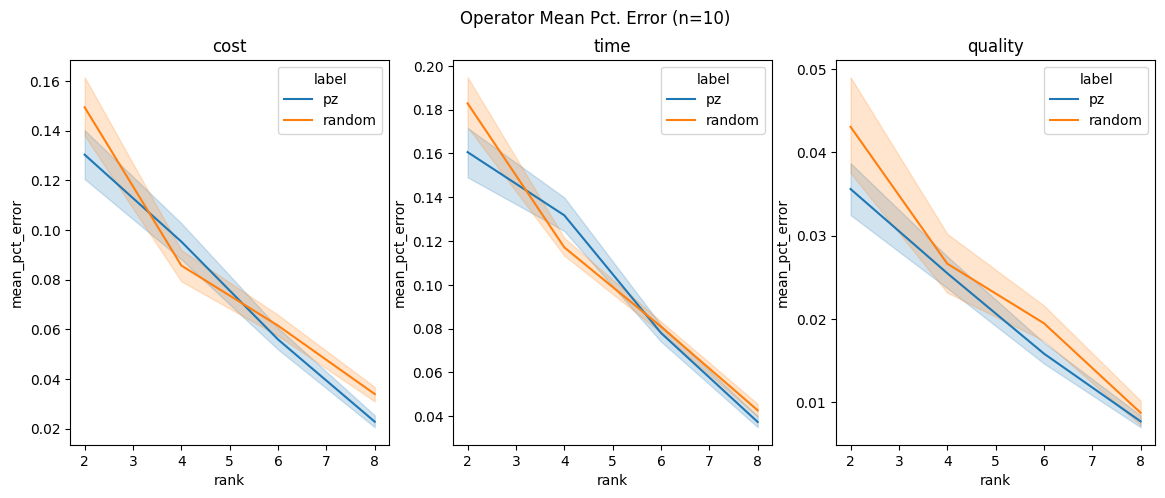

In [658]:
import matplotlib.pyplot as plt
import seaborn as sn

fig1, axs = plt.subplots(1, 3, figsize=(14, 5))
for n in [10]:
    for idx, metric in enumerate(["cost", "time", "quality"]):
        results_df = convert_error_df[(convert_error_df.num_samples == n) & (convert_error_df.metric == metric)]
        g = sn.lineplot(results_df[results_df.num_samples == n], x="rank", y="mean_pct_error", hue="label", ax=axs[idx])
        g.set_title(metric)
    fig1.suptitle(f"Operator Mean Pct. Error (n={n})")
    fig1.savefig(f"opt-results/error-num-samples-{n}.png")


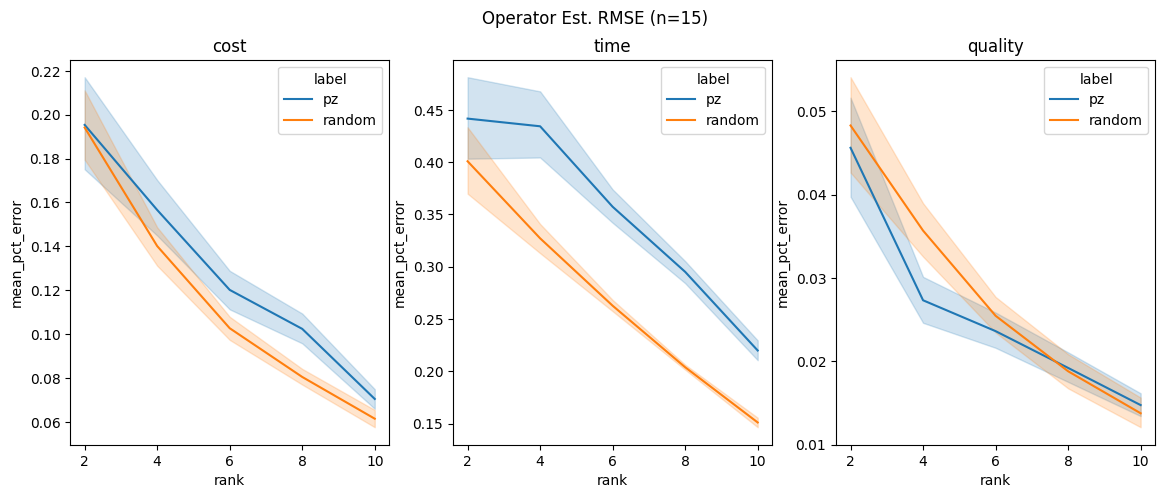

In [659]:
import matplotlib.pyplot as plt
import seaborn as sn

fig2, axs = plt.subplots(1, 3, figsize=(14, 5))
for n in [15]:
    for idx, metric in enumerate(["cost", "time", "quality"]):
        results_df = convert_error_df[(convert_error_df.num_samples == n) & (convert_error_df.metric == metric)]
        g = sn.lineplot(results_df[results_df.num_samples == n], x="rank", y="mean_pct_error", hue="label", ax=axs[idx])
        g.set_title(metric)
    fig2.suptitle(f"Operator Est. RMSE (n={n})")
    fig2.savefig(f"opt-results/error-num-samples-{n}.png")

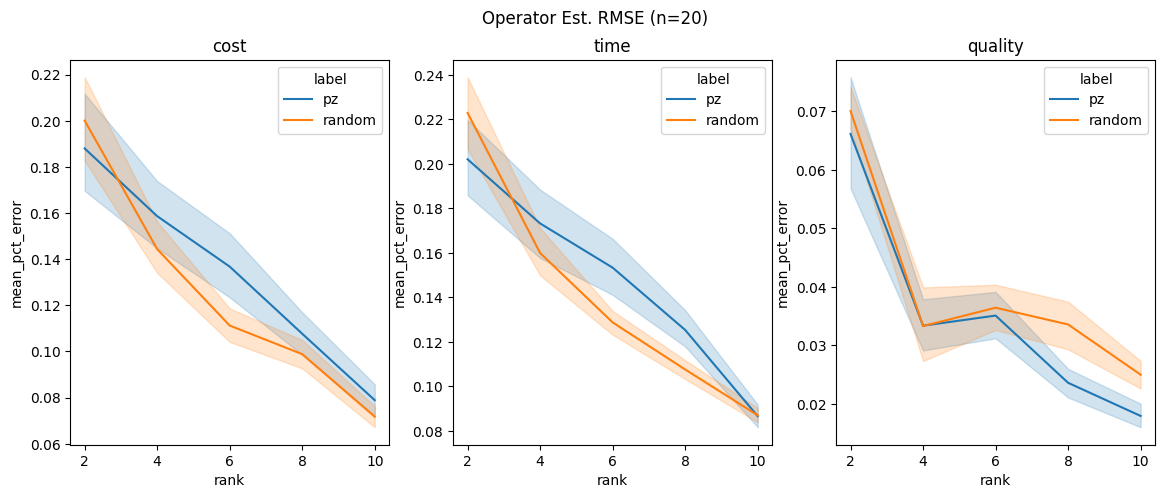

In [660]:
import matplotlib.pyplot as plt
import seaborn as sn

fig3, axs = plt.subplots(1, 3, figsize=(14, 5))
for n in [20]:
    for idx, metric in enumerate(["cost", "time", "quality"]):
        results_df = convert_error_df[(convert_error_df.num_samples == n) & (convert_error_df.metric == metric)]
        g = sn.lineplot(results_df[results_df.num_samples == n], x="rank", y="mean_pct_error", hue="label", ax=axs[idx])
        g.set_title(metric)
    fig3.suptitle(f"Operator Est. RMSE (n={n})")
    fig3.savefig(f"opt-results/error-num-samples-{n}.png")

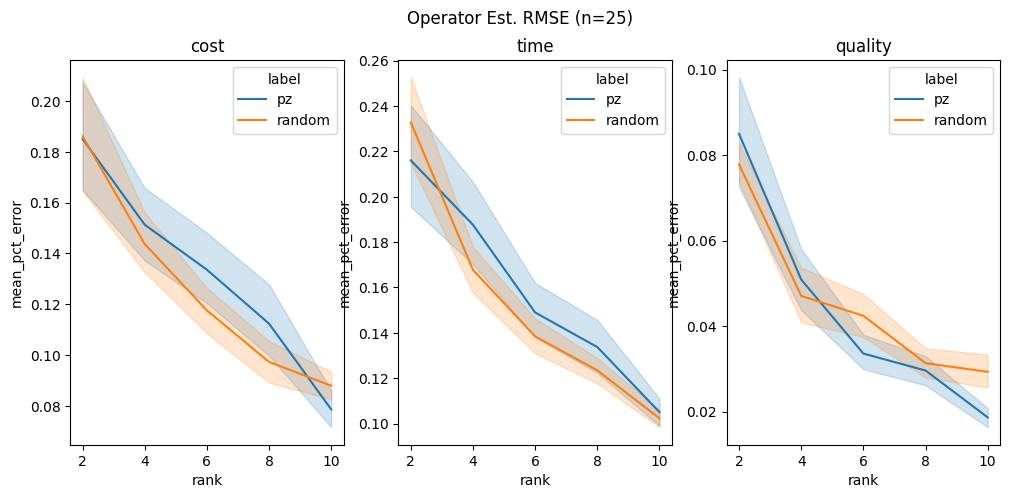

In [663]:
import matplotlib.pyplot as plt
import seaborn as sn

fig4, axs = plt.subplots(1, 3, figsize=(12, 5))
for n in [25]:
    for idx, metric in enumerate(["cost", "time", "quality"]):
        results_df = convert_error_df[(convert_error_df.num_samples == n) & (convert_error_df.metric == metric)]
        g = sn.lineplot(results_df[results_df.num_samples == n], x="rank", y="mean_pct_error", hue="label", ax=axs[idx])
        g.set_title(metric)
    fig4.suptitle(f"Operator Est. RMSE (n={n})")
    fig4.savefig(f"opt-results/error-num-samples-{n}.png")

## Exploration

In [223]:
np.set_printoptions(precision=5, linewidth=250)

In [29]:
def run_trial_with_losses(rank, raw_matrices_dict, trial_idx):
    # only use single torch thread
    torch.set_num_threads(2)

    # create a sample matrix; every raw matrix will have the same shape for a given logical_op_id;
    # we use the "cost" matrix to get the shape
    num_rows, num_cols = raw_matrices_dict["cost"].shape

    # create a sample mask
    sample_mask = create_sample_matrix(num_rows, num_cols, rank, seed=trial_idx)

    # run matrix completion
    completed_matrices, losses, recon_losses, col_losses = complete_matrices(raw_matrices_dict, sample_mask, rank)

    return completed_matrices, sample_mask, losses, recon_losses, col_losses

In [17]:
n, rank, logical_op_id, trial_idx, metric = 15, 6, "6deb6d2fa9", 14, "time"

gt_matrix = num_samples_to_raw_matrices[n][logical_op_id][metric]
sample_mask = completed_matrix_sample_masks[n][rank][logical_op_id][trial_idx]
comp_matrix = completed_matrix_data[n][rank][logical_op_id][trial_idx][metric]

In [34]:
from concurrent.futures import ThreadPoolExecutor

# run NUM_TRIALS trials
with ThreadPoolExecutor(max_workers=2) as executor:
    import time
    t0 = time.time()
    results = list(executor.map(
            lambda x: run_trial_with_losses(**x),
            [{"rank": rank,
              "raw_matrices_dict": num_samples_to_raw_matrices[n][logical_op_id],
              "trial_idx": trial_idx}
              for trial_idx in range(1)],
        )
    )
    print(f"total time: {time.time() - t0:.3f}")
    torch.set_num_threads(35)
    # torch.set_num_interop_threads(35)

outputs = run_trial_with_losses(rank, num_samples_to_raw_matrices[n][logical_op_id], trial_idx)

total time: 9.522


In [ ]:
# outputs = new_run_trial(rank, num_samples_to_raw_matrices[n][logical_op_id], trial_idx)
new_comp_matrices = {rank: [] for rank in [2, 4, 6, 8, 10]}
new_sample_masks = {rank: [] for rank in [2, 4, 6, 8, 10]}
for rank in [2, 4, 6, 8, 10]:
    for trial_idx in range(10):
        print(f"{rank} -- {trial_idx}")
        new_comp_matrices, sample_mask = outputs[0], outputs[1]
        # losses, recon_losses, col_losses = outputs[2], outputs[3], outputs[4]
        new_comp_matrices[rank].append(new_comp_matrices[metric])
        new_sample_masks[rank].append(sample_mask)


In [ ]:
# randomly sample a matrix from the groundtruth data
rng = np.random.default_rng(seed=NUM_TRIALS*trial_idx + n * (rank-1))
sample_row_indices = rng.choice(np.arange(n), size=rank, replace=False)
random_matrix = gt_matrix[sample_row_indices, :]

# compute groundtruth estimates of (per-operator) metric
true_col_means = np.mean(gt_matrix, axis=0)

# compute reconstructed estimates of (per-operator) metric
est_col_means = np.mean(comp_matrix, axis=0)

# new
new_est_col_means = np.mean(new_comp_matrix, axis=0)

# compute random sample estimates of (per-operator) metric
est_random_means = np.mean(random_matrix, axis=0)

# compute error from mean divided by size of mean
mean_pct_error = np.mean(np.abs(est_col_means - true_col_means)/true_col_means)
new_mean_pct_error = np.mean(np.abs(new_est_col_means - true_col_means)/true_col_means)
random_mean_pct_error = np.mean(np.abs(est_random_means - true_col_means)/true_col_means)

In [ ]:
# nan_est_col_means = np.mean(comp_matrix, axis=0, where=sample_mask.astype(bool))

In [ ]:
# np.mean(np.abs(nan_est_col_means - true_col_means)/true_col_means)

In [ ]:
pz_has_bad_cell_indices = []
random_has_bad_cell_indices = []
for trial_idx in range(100):
    sample_mask = completed_matrix_sample_masks[n][rank][logical_op_id][trial_idx]
    if sample_mask[12, 0]:
        pz_has_bad_cell_indices.append(trial_idx)

    rng = np.random.default_rng(seed=NUM_TRIALS*trial_idx + n * (rank-1))
    sample_row_indices = rng.choice(np.arange(n), size=rank, replace=False)
    if int(12 in sample_row_indices):
        random_has_bad_cell_indices.append(trial_idx)

In [ ]:
new_mean_pct_error

In [ ]:
mean_pct_error

In [ ]:
random_mean_pct_error

In [ ]:
fig, ax = plt.subplots()
ax.plot([idx for idx in range(len(losses))], losses, label="loss")
ax.plot([idx for idx in range(len(losses))], recon_losses, label="recon_loss")
ax.plot([idx for idx in range(len(losses))], col_losses, label="col_loss")
ax.set_ylabel("loss")
ax.set_xlabel("epoch")
ax.legend()
plt.show()

In [ ]:
error_df[
    (error_df.num_samples == n)
    & (error_df['rank'] == rank)
    & (error_df.logical_op_id == logical_op_id)
    # & (error_df.trial_idx == trial_idx)
    & (error_df.metric == "time")
    # & (error_df.label == "pz")
][['trial_idx','label','mean_pct_error']].groupby('label').mean()

In [ ]:
import matplotlib.pyplot as plt

plt.hist(error_df[error_df.label == "random"].mean_pct_error, bins=50, alpha=0.4, label='random')
plt.hist(error_df[error_df.label == "pz"].mean_pct_error, bins=50, alpha=0.4, label='pz')
plt.legend()
plt.show()

#### Matrix Rank

In [733]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
pca.fit(raw_matrix)
format_arr = [float(f"{float(val):.5f}") for val in pca.explained_variance_ratio_]
print(f"{format_arr}")
sum(format_arr[:4])

[0.82275, 0.11193, 0.0446, 0.01259, 0.00797, 8e-05, 5e-05]


In [734]:
sum(format_arr[:4])

0.99187

## BioDex

In [675]:
import datasets

dataset = datasets.load_dataset("BioDEX/BioDEX-ICSR")
train_dataset = dataset['train']
test_dataset = dataset['test']

In [703]:
test_dataset[1]['target'].split('\n')

['serious: 1',
 'patientsex: 1',
 'drugs: BOSUTINIB, IMATINIB MESYLATE, NILOTINIB',
 'reactions: High-grade B-cell lymphoma, Second primary malignancy',
 '']

In [698]:
import json

with open('opt-profiling-data/biodex-baseline-gpt-4o-mini-records.json', 'r') as f:
    bio_results = json.load(f)

In [704]:
with open('opt-profiling-data/biodex-baseline-gpt-4o-mini-profiling.json','r') as f:
    bio_stats = json.load(f)

In [712]:
bio_stats['plan_stats']['ac928c7db0']['total_plan_cost']

0.012113849999999999

In [ ]:
def get_set_precision_and_recalls(preds: list, targets: list):
    # compute precision and recall
    s_preds = set(preds)
    s_targets = set(targets)

    intersect = s_preds.intersection(s_targets)

    precision = len(intersect) / len(s_preds) if len(s_preds) > 0 else 0.0
    recall = len(intersect) / len(s_targets)

    return precision, recall

def score(record_dict, target_dict):
    serious_sim = record_dict['serious'] == target_dict['serious']
    patientsex_sim = record_dict['patientsex'] == target_dict['patientsex']

    drugs_p, drugs_r = get_set_precision_and_recalls(record_dict['drugs'], target_dict['drugs'])
    reactions_p, reactions_r = get_set_precision_and_recalls(record_dict['reactions'], target_dict['reactions'])

    weights = [1 / 6, 1 / 6, 1 / 3, 1 / 3]
    precision = [serious_sim, patientsex_sim, drugs_p, reactions_p]
    recall = [serious_sim, patientsex_sim, drugs_r, reactions_r]

    precision = sum([w * p for w, p in zip(weights, precision)])
    recall = sum([w * r for w, r in zip(weights, recall)])

    if precision and recall:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0
    return precision, recall, f1

In [685]:
train_text_lengths, val_train_text_lengths  = [], []
for idx, elt in enumerate(train_dataset):
    train_text_lengths.append(len(elt['fulltext']))
    if idx < 25:
        val_train_text_lengths.append(len(elt['fulltext']))


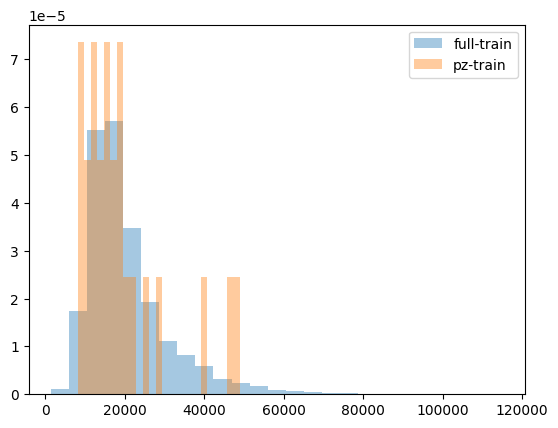

In [686]:
import matplotlib.pyplot as plt

fig
plt.hist(train_text_lengths, density=True, bins=25, alpha=0.4, label='full-train')
plt.hist(val_train_text_lengths, density=True, bins=25, alpha=0.4, label='pz-train')
plt.legend()
plt.show()